### Plots the PDFs of the extraction and the posterior

In [1]:
import numpy as np
import os, pickle
from scipy.sparse.linalg import eigsh
import JWS_SWOT_toolbox as swot
import matplotlib.pyplot as plt
import scipy.linalg as la

PICKLES = "./pickles"
KARIN_NA_PATH = f"{PICKLES}/karin_NA_tmean.pkl"

def load(p):
    with open(p, "rb") as f:
        return pickle.load(f)

# Balanced fields (mean fields) by smoothing scale
def path_nonoise(km):  # "ground truth" 
    return f"{PICKLES}/balanced_extraction_synth_NA_tmean_nonoise_sm_{km}km.pkl"

def path_withnoise(km):  # extracted balanced field
    return f"{PICKLES}/balanced_extraction_synth_NA_tmean_sm_{km}km.pkl"

In [ ]:
# use iterative eigenvalue solver to generate our L's and save them
SCALE_KM = 8
PICKLES = "./pickles"
POST_C_PATH = f"{PICKLES}/posterior_full_synth_NA_tmean_sm_{SCALE_KM}km.pkl"

# low rank solver for no cholesky
# def lowrank_factor(C, k=512, tol=1e-12):
#     C = 0.5*(C + C.T)
#     k = min(max(1, k), C.shape[0]-2)
#     w, Q = eigsh(C, k=k, which='LA')          # top eigenpairs
#     idx = np.argsort(w)[::-1]
#     w, Q = w[idx], Q[:, idx]
#     keep = w > tol
#     w, Q = w[keep], Q[:, keep]
#     L = Q * np.sqrt(w)[None, :]               # C ≈ L L^T
#     print(f"{k}th eigenvalue: {w[min(k-1, len(w)-1)]:.6e}")
#     return L

C = load(POST_C_PATH)
print(C.shape)
w, Q = np.linalg.eigh(C)
wmin, wmax = float(w.min()), float(w.max())

w_clipped = np.clip(w, 1e-10, None)  # remove negative/zero eigenvalues
C_psd = (Q * w_clipped) @ Q.T

Lfac, lower  = la.cho_factor(C_psd  + np.eye(C.shape[0]) * 1e-3, lower=True)
Ltri = np.tril(Lfac)
# L = lowrank_factor(C, k=2048)
# with open(L_PATH, "wb") as f:
#     pickle.dump(L, f)
# print(f"Saved low-rank factor to {L_PATH}")

(6780, 6780)


In [10]:
print(wmin, wmax)

-1730.9780017074681 134.4560300526041


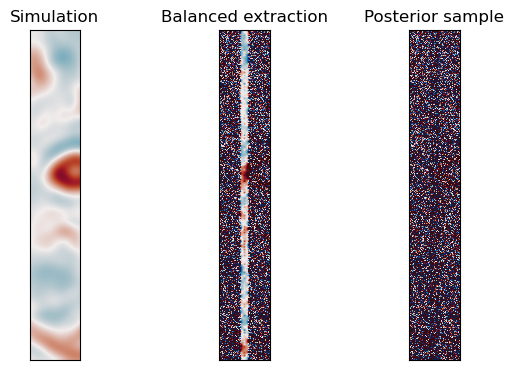

In [15]:
import h5py
# Read in the pickle file L we just saved and plot to check 

time = 10 

# L_PATH = f"{PICKLES}/posterior_factor_{SCALE_KM}km.pkl"
# with open(L_PATH, "rb") as f:
#     L = pickle.load(f)
# print("Loaded L:", L.shape)

# # test the Julia extraction
# L_PATH = "./pickles/L_full_synth_NA_tmean_sm_2km.h5"
# with h5py.File(L_PATH, "r") as f:
#     key = 'L'
#     L = f[key][()]  # read the dataset into memory as a NumPy array
#     print("Loaded L:", L.shape, L.dtype)

karin = load(KARIN_NA_PATH) # reading in for lats
dx_m = float(karin.dx_km) * 1e3
dy_m = float(karin.dy_km) * 1e3
lat_1d = np.asarray(karin.lat)[0, :, 0] # for gvort

# --- inputs balanced extraction and original fields ---
ht_sim = np.asarray(load(path_nonoise(SCALE_KM)), dtype=float)   # (T, y, x) ground truth
ht_ext = np.asarray(load(path_withnoise(SCALE_KM)), dtype=float) # (T, y, x) balanced extraction
T, ny, nx = ht_ext.shape            

# posterior sample: x ~ N(mu, C) with C ≈ L L^T
mu = (ht_ext[time] * 100.0).ravel() # (n,), cm
z  = np.random.randn(mu.size) 
ht_post = (mu + Ltri @ z).reshape(ny, nx) / 100.0      # meters

# compute the vorticitys
sim_vort = swot.compute_geostrophic_vorticity_5pt(ht_sim[time], dx_m, dy_m, lat_1d)
ext_vort = swot.compute_geostrophic_vorticity_5pt(ht_ext[time], dx_m, dy_m, lat_1d)
post_vort = swot.compute_geostrophic_vorticity_5pt(ht_post, dx_m, dy_m, lat_1d)

fig, axes = plt.subplots(1, 3, figsize=(7, 3.8), sharex=True, sharey=True)
titles = ["Simulation", "Balanced extraction", "Posterior sample"]
vmin, vmax = -1.5, 1.5

ims = []
for ax, data, title in zip(axes, [sim_vort, ext_vort, post_vort], titles):
    im = ax.imshow(data, origin="lower", cmap='cmo.balance', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    ims.append(im)

fig.tight_layout()
plt.savefig(f"posterior_sim_ext_{SCALE_KM}km_t{time}.png", dpi=150)
plt.show()


In [17]:
# Now we loop over times and samples for the posterior and for each scale and save all the vorticies

SCALES = [1, 2, 4, 8, 16] # loop over
NSAMPLES = 10
TIMES = T

results = {}

for km in SCALES: 
    print(f"{km} km")
    sim_vort_all = np.zeros((T, ny, nx))
    ext_vort_all = np.zeros((T, ny, nx))
    post_vort_all = np.zeros((T, NSAMPLES, ny, nx))
    
    ht_sim = np.asarray(load(path_nonoise(km)), dtype=float)   # (T, y, x)
    ht_ext = np.asarray(load(path_withnoise(km)), dtype=float) # (T, y, x)
    T, ny, nx = ht_ext.shape

    L_PATH = f"{PICKLES}/posterior_factor_{km}km.pkl"
    with open(L_PATH, "rb") as f:
        L = pickle.load(f)
    print("Loaded L:", L.shape)       

    for t in range(0, TIMES):
        # posterior sample: x ~ N(mu, C) with C ≈ L L^T
        mu = ht_ext[t] * 100 # in cm for our extraction 
        r = L.shape[1]
        for s in range(0, NSAMPLES): # sample posterior
            z = np.random.randn(r) # new seed
            ht_post = (mu.ravel() + L @ z).reshape(ny, nx) / 100 # back into meters
            post_vort = swot.compute_geostrophic_vorticity_5pt(ht_post, dx_m, dy_m, lat_1d)
            post_vort_all[t, s] = post_vort

        # compute the vorticitys for balanced and sim 
        sim_vort = swot.compute_geostrophic_vorticity_5pt(ht_sim[t], dx_m, dy_m, lat_1d)
        ext_vort = swot.compute_geostrophic_vorticity_5pt(ht_ext[t], dx_m, dy_m, lat_1d)

        sim_vort_all[t] = sim_vort
        ext_vort_all[t] = ext_vort

    results[km] = dict(
        sim=sim_vort_all,
        ext=ext_vort_all,
        post=post_vort_all,
    )
print("Done")

1 km
Loaded L: (23700, 2048)
2 km
Loaded L: (23700, 2048)
4 km
Loaded L: (23700, 512)
8 km
Loaded L: (23700, 512)
16 km
Loaded L: (23700, 512)
Done


/scratch/jskinner1/job_43993224/ipykernel_1670089/1235966636.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


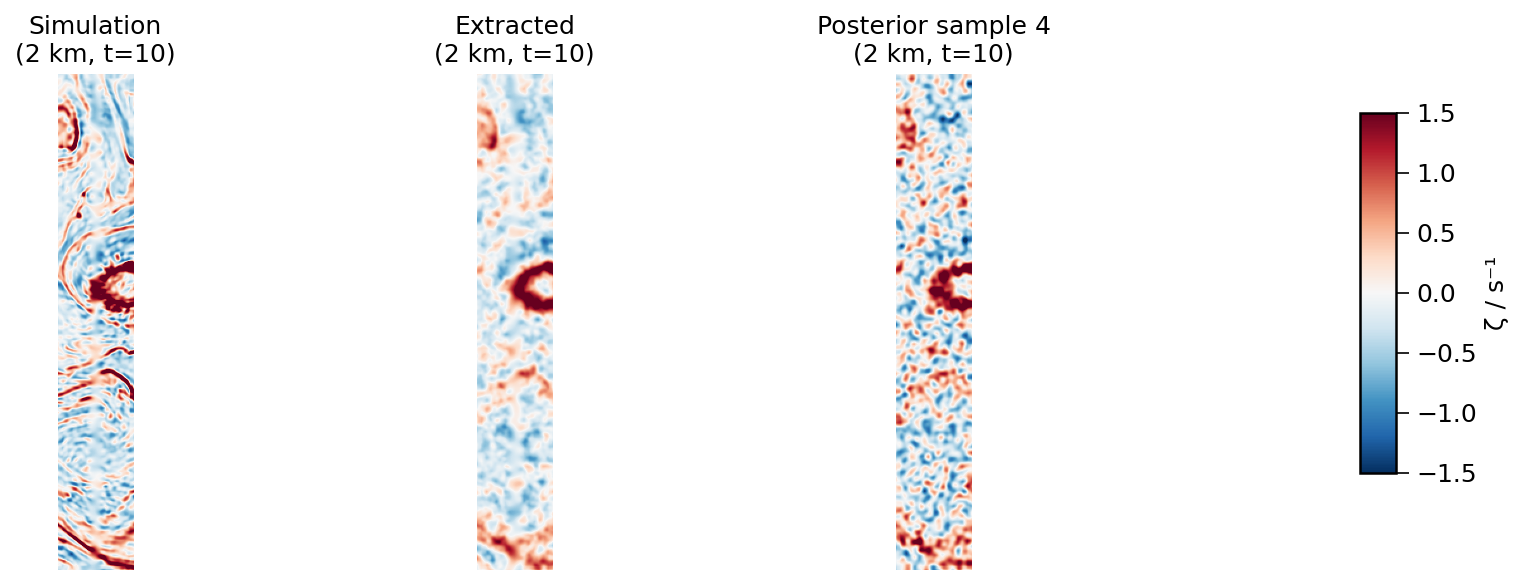

In [19]:
# check the vort calculation
km = 2          
t_show = 10     
sample = 4      # posterior sample 

data = results[km]
sim_vort = data["sim"][t_show]
ext_vort = data["ext"][t_show]
post_vort = data["post"][t_show, sample] 

# --- Setup figure layout ---
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
titles = ["Simulation", "Extracted", f"Posterior sample {sample}"]

# --- Plot each field ---
for ax, field, title in zip(axes, [sim_vort, ext_vort, post_vort], titles):
    im = ax.imshow(field, cmap="RdBu_r", vmin=vmin, vmax=vmax, origin="lower")
    ax.set_title(f"{title}\n({km} km, t={t_show})")
    ax.axis("off")

# --- Add colorbar ---
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cax, label="ζ / s⁻¹")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


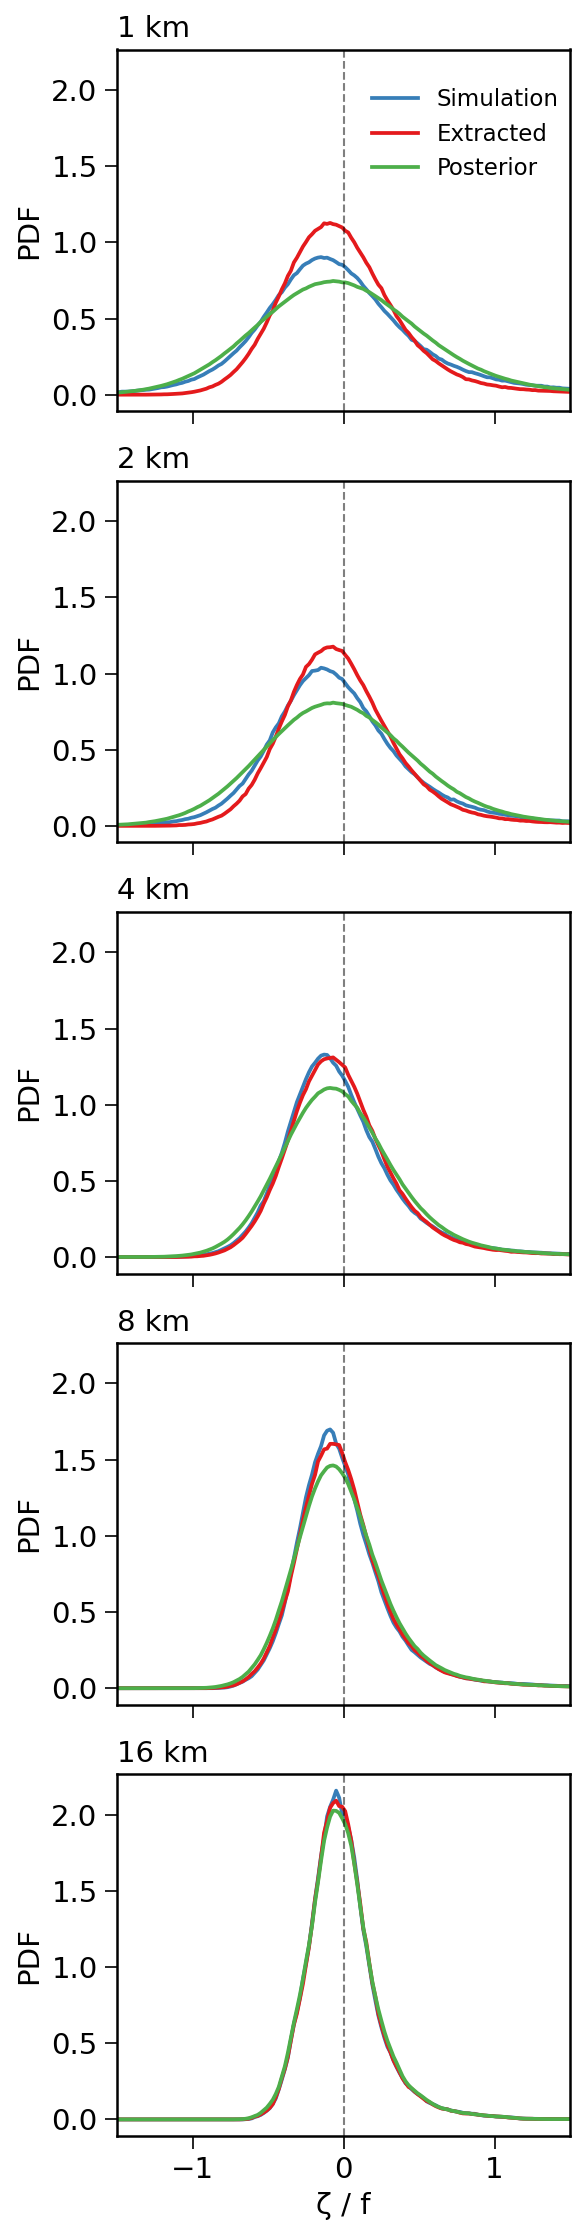

In [21]:
def finite_flat(*arrays):
    outs = []
    for a in arrays:
        v = np.asarray(a, dtype=float).ravel()
        outs.append(v[np.isfinite(v)])
    return outs

def pdf_shared_bins(vals_list, bins=200, clip=(0.5, 99.5)):
    
    allv = np.concatenate(vals_list)
    lo, hi = -2, 2
    edges = np.linspace(lo, hi, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    xs_list, pdf_list = [], []
    for v in vals_list:
        v = np.asarray(v)
        v = v[np.isfinite(v)]
        v = v[(v >= lo) & (v <= hi)] # Drop outliers
        h, _ = np.histogram(v, bins=edges, density=True)
        xs_list.append(centers)
        pdf_list.append(h)
    return centers, pdf_list

fig, axes = plt.subplots(len(SCALES), 1, figsize=(4, 3.0 * len(SCALES)), sharex=True, sharey=True, dpi=150)
swot.set_plot_style()

pdfs = {} 
for ax, km in zip(axes, SCALES):
    data = results[km]

    # Flatten data
    sim_all, = finite_flat(data["sim"])
    ext_all, = finite_flat(data["ext"])
    post_all, = finite_flat(data["post"])

    # Compute PDFs
    x, (pdf_sim, pdf_ext, pdf_post) = pdf_shared_bins(
        [sim_all, ext_all, post_all], bins=200, clip=(-2, 2)
    )

    pdfs[km] = (x, pdf_sim, pdf_ext, pdf_post) # save so we can get moments

    # Plot
    ax.plot(x, pdf_sim, lw=1.8, label="Simulation")
    ax.plot(x, pdf_ext, lw=1.8, label="Extracted")
    ax.plot(x, pdf_post, lw=1.8, label="Posterior")
    ax.set_xlim(-1.5, 1.5)
    ax.set_title(f"{km} km", loc='left', fontsize=14)
    if ax is axes[4]:
        ax.set_xlabel("ζ / f", fontsize=14)
    ax.set_ylabel("PDF", fontsize=14)
    ax.axvline(0, color="k", lw=1.0, ls="--", alpha=0.5)
    ax.tick_params(axis="both", which="major", labelsize=14)

# --- Shared legend & layout ---
handles, labels = axes[-1].get_legend_handles_labels()
axes[0].legend(loc="upper right", frameon=False, fontsize=11, bbox_to_anchor=(1.02, 0.95))
fig.tight_layout()
plt.savefig('PDFS.pdf')
plt.show()

C = LDL^T 
C = P^TLDL^TP is a diagonal with non-zeros on on diagonal some values are -10^_13, set these to zero 
P^TL sqrt(D) is my cholesky factor 

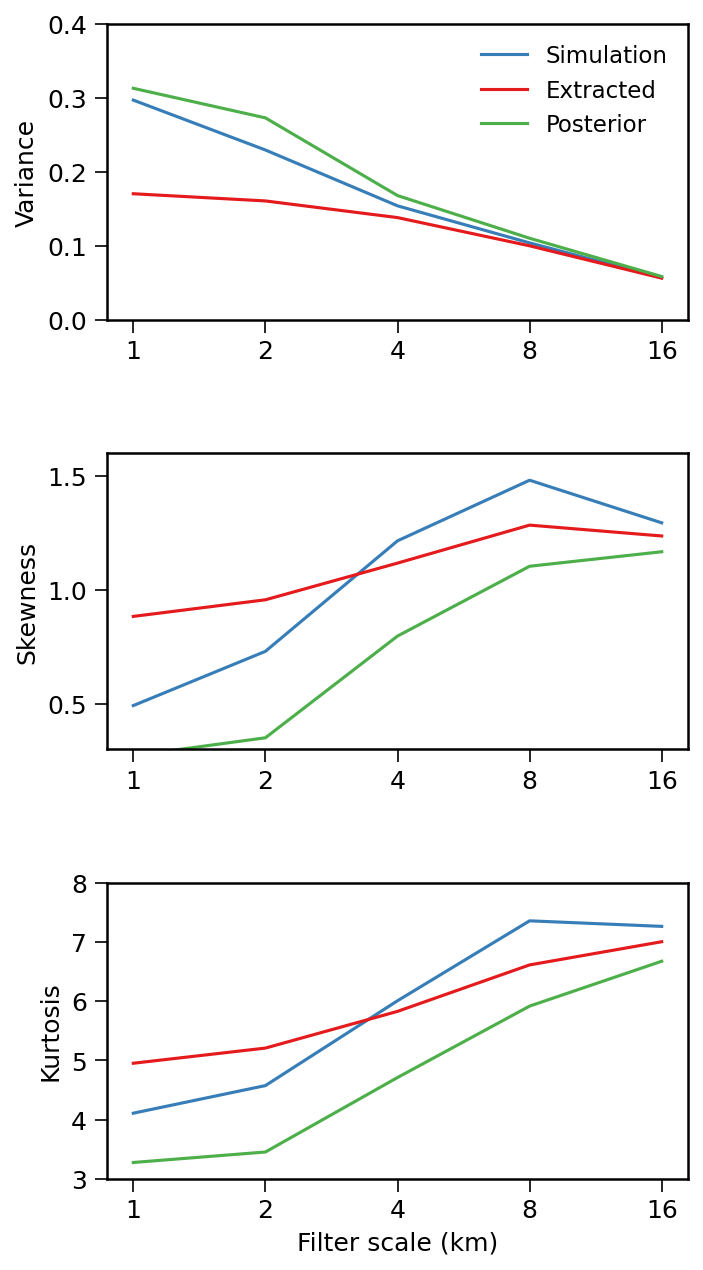

In [24]:
def hist_moments(x, p):
    """Compute mean, variance, skewness, kurtosis from histogram (density normalized)."""
    dx = x[1] - x[0]
    w = p * dx
    m1 = np.sum(x * w)
    c = x - m1
    m2 = np.sum((c**2) * w)
    m3 = np.sum((c**3) * w)
    m4 = np.sum((c**4) * w)
    skew = m3 / (m2 ** 1.5)
    kurt = m4 / (m2 ** 2)
    return m1, m2, skew, kurt

scales = []
var_sim, var_ext, var_post = [], [], []
skw_sim, skw_ext, skw_post = [], [], []
kur_sim, kur_ext, kur_post = [], [], []

for km, (x, pdf_sim, pdf_ext, pdf_post) in pdfs.items():
    _, v_s, s_s, k_s = hist_moments(x, pdf_sim)
    _, v_e, s_e, k_e = hist_moments(x, pdf_ext)
    _, v_p, s_p, k_p = hist_moments(x, pdf_post)

    scales.append(km)
    var_sim.append(v_s); var_ext.append(v_e); var_post.append(v_p)
    skw_sim.append(s_s); skw_ext.append(s_e); skw_post.append(s_p)
    kur_sim.append(k_s); kur_ext.append(k_e); kur_post.append(k_p)
    

plt.figure(figsize=(5, 10), dpi=150)
ax1 = plt.subplot(3, 1, 1)
plt.subplots_adjust(hspace=0.7)
ax1.plot(scales, var_sim,  "-",lw=1.5, label="Simulation")
ax1.plot(scales, var_ext,  "-",lw=1.5, label="Extracted")
ax1.plot(scales, var_post, "-",lw=1.5, label="Posterior")
ax1.set_ylabel("Variance", fontsize=12)
ax1.tick_params(axis="both", labelsize=12)
ax1.legend(frameon=False, fontsize=11, ncols=1)
ax1.set_xticks(scales)
ax1.set_xticklabels(scales)
ax1.set_ylim(0, 0.4)

ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(scales, skw_sim,  "-", lw=1.5)
ax2.plot(scales, skw_ext,  "-", lw=1.5)
ax2.plot(scales, skw_post, "-", lw=1.5)
ax2.set_ylabel("Skewness", fontsize=12)
ax2.tick_params(axis="both", labelsize=12)
ax2.set_ylim(0.3, 1.6)

ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(scales, kur_sim,  "-", lw=1.5)
ax3.plot(scales, kur_ext,  "-", lw=1.5)
ax3.plot(scales, kur_post, "-", lw=1.5)
ax3.set_ylabel("Kurtosis", fontsize=12)
ax3.set_xlabel("Filter scale (km)", fontsize=12)
ax3.tick_params(axis="both", labelsize=12)
ax3.set_ylim(3, 8)

for ax in [ax1, ax2, ax3]:
    ax.set_xscale("log", base=2)
    ax.set_xticks(SCALES)
    ax.set_xticklabels([str(k) for k in SCALES])

plt.subplots_adjust(hspace=0.45)
#plt.tight_layout()
plt.savefig("vort-moments.pdf")
plt.show()


In [14]:
# Load posterior mean on 1 km grid
ht_1km_all = load(MEAN_1KM_PATH)   # (T, y, x)
T, ny, nx = ht_1km_all.shape

n_samples = 10
rng = np.random.default_rng(0)
TIMES_FOR_BINS = min(10, T)  # subset of times to set shared bin edges per scale

def finite_flat(a):
    a = np.asarray(a)
    return a[np.isfinite(a)]

def hist_mean_over_time(vals_T, edges):
    # vals_T: list of 1D finite arrays (one per time)
    H_T = [np.histogram(v, bins=edges, density=True)[0] for v in vals_T]
    return np.mean(np.stack(H_T, axis=0), axis=0)

# Outputs (per-scale)
centers_dict   = {}
H_no_mean_dict = {}
H_wi_mean_dict = {}
H_po_mean_dict = {}

for km in SCALES:
    print(f"{km} km")
    # Load fields already filtered at this scale
    ht_no_all = np.asarray(load(path_nonoise(km)), dtype=float)   # (T, y, x)
    ht_wi_all = np.asarray(load(path_withnoise(km)), dtype=float) # (T, y, x)

    # Smoothing sigmas for posterior samples to match this scale
    sy, sx = sigma_pixels(km, dx_m, dy_m)

    # --- Pass 1: set common bin edges for this scale (subset of times) ---
    los, his = [], []
    for t in range(TIMES_FOR_BINS):
        # simulation & extracted vorticity
        z_no = swot.compute_geostrophic_vorticity_5pt(ht_no_all[t], dx_m, dy_m, lat_1d)
        z_wi = swot.compute_geostrophic_vorticity_5pt(ht_wi_all[t], dx_m, dy_m, lat_1d)

        # posterior samples (vectorized), then smooth to this scale
        mu_cm = ht_1km_all[t].ravel() * 100.0
        N = mu_cm.size
        Z = rng.standard_normal((N, n_samples))                       # (N, S)
        ssh_samples = ((mu_cm[:, None] + L @ Z) / 100.0).T            # (S, N) m
        ssh_samples = ssh_samples.reshape(n_samples, ny, nx)          # (S, y, x)
        ssh_smooth = gaussian_filter(ssh_samples, sigma=(0, sy, sx), mode="nearest")

        a = finite_flat(z_no)
        b = finite_flat(z_wi)
        c = []
        for s in range(n_samples):
            z_po = swot.compute_geostrophic_vorticity_5pt(ssh_smooth[s], dx_m, dy_m, lat_1d)
            c.append(finite_flat(z_po))
        c = np.concatenate(c)

        all_vals = np.concatenate([a, b, c])
        los.append(np.percentile(all_vals, 0.5))
        his.append(np.percentile(all_vals, 99.5))

    lo, hi = float(min(los)), float(max(his))
    edges = np.linspace(lo, hi, 121)
    centers = 0.5 * (edges[:-1] + edges[1:])

    # --- Pass 2: compute time-averaged PDFs for this scale ---
    sim_vals_T, ext_vals_T = [], []
    post_hist_T = []  # we will store histograms directly for the posterior

    for t in range(T):
        print(f"t={t}", end="\r")
        # simulation & extracted
        z_no = swot.compute_geostrophic_vorticity_5pt(ht_no_all[t], dx_m, dy_m, lat_1d)
        z_wi = swot.compute_geostrophic_vorticity_5pt(ht_wi_all[t], dx_m, dy_m, lat_1d)
        sim_vals_T.append(finite_flat(z_no))
        ext_vals_T.append(finite_flat(z_wi))

        # posterior: average of sample histograms at time t
        mu_cm = ht_1km_all[t].ravel() * 100.0
        N = mu_cm.size
        Z = rng.standard_normal((N, n_samples))
        ssh_samples = ((mu_cm[:, None] + L @ Z) / 100.0).T.reshape(n_samples, ny, nx)
        ssh_smooth = gaussian_filter(ssh_samples, sigma=(0, sy, sx), mode="nearest")

        H_pos = []
        for s in range(n_samples):
            z_po = swot.compute_geostrophic_vorticity_5pt(ssh_smooth[s], dx_m, dy_m, lat_1d)
            H_pos.append(np.histogram(finite_flat(z_po), bins=edges, density=True)[0])
        post_hist_T.append(np.mean(np.stack(H_pos, axis=0), axis=0))

    # time-averaged PDFs
    H_no_mean = hist_mean_over_time(sim_vals_T, edges)
    H_wi_mean = hist_mean_over_time(ext_vals_T, edges)
    H_po_mean = np.mean(np.stack(post_hist_T, axis=0), axis=0)

    # store
    centers_dict[km]   = centers
    H_no_mean_dict[km] = H_no_mean
    H_wi_mean_dict[km] = H_wi_mean
    H_po_mean_dict[km] = H_po_mean

# Optional: save to pickle for quick reload later
try:
    pdf_data = {
        "centers": centers_dict,
        "H_no_mean": H_no_mean_dict,
        "H_wi_mean": H_wi_mean_dict,
        "H_po_mean": H_po_mean_dict,
        "n_samples": n_samples,
        "times": T,
        "scales": list(SCALES),
    }
    if 'FINAL_DATA_PATH' in globals():
        import pickle
        with open(FINAL_DATA_PATH, "wb") as f:
            pickle.dump(pdf_data, f)
        print(f"Saved PDF data to {FINAL_DATA_PATH}")
except Exception as e:
    print("Skip save (no FINAL_DATA_PATH or write issue):", e)


1 km


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 23700 is different from 512)

NameError: name 'centers_dict' is not defined

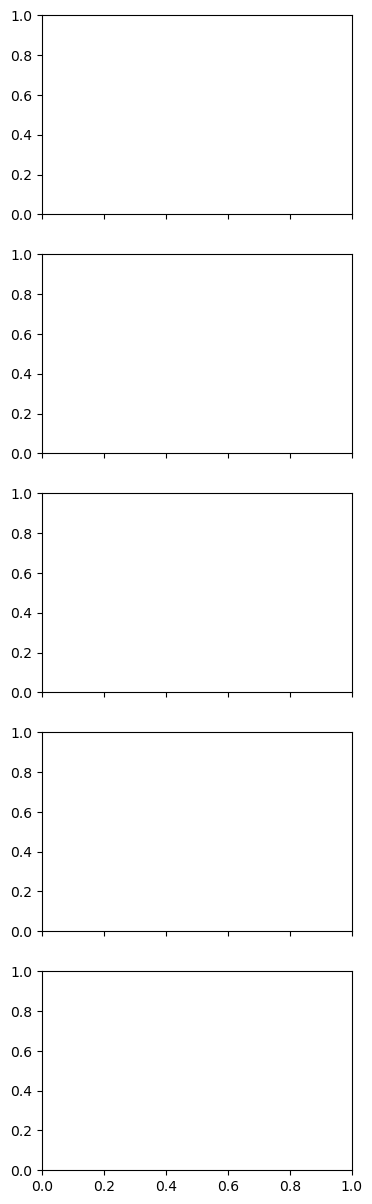

In [13]:
fig, axes = plt.subplots(5, 1, figsize=(4, 15), sharex=True, sharey=True)
axes = axes.ravel()

for ax, km in zip(axes, SCALES):
    ax.plot(centers_dict[km], H_no_mean_dict[km], lw=2, label="Simulation ζ/f")
    ax.plot(centers_dict[km], H_wi_mean_dict[km], lw=2, label="Extracted ζ/f")
    ax.plot(centers_dict[km], H_po_mean_dict[km], lw=2, label="Posterior ζ/f")
    ax.set_title(f"{km} km filtered")
    ax.axvline(0, color="k", ls="-", lw=1.0, alpha=0.7)
    ax.set_xlim(-2, 2)

# axis labels
axes[-1].set_xlabel("Geostrophic vorticity ζ/f")
for ax in axes:
    ax.set_ylabel("Probability density")

# legend only in first plot
axes[0].legend(
    loc="upper right",
    frameon=False,
    fontsize=9
)

fig.tight_layout()
plt.savefig("PDFS.pdf")
plt.show()

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# --- Compute variance, skewness, kurtosis from PDFs ---
scales = np.array(SCALES, dtype=float)
var_no, var_wi, var_po = [], [], []
skew_no, skew_wi, skew_po = [], [], []
kurt_no, kurt_wi, kurt_po = [], [], []

for km in SCALES:
    x = centers_dict[km]
    # normalized PDFs
    p_no = H_no_mean_dict[km] / np.trapz(H_no_mean_dict[km], x)
    p_wi = H_wi_mean_dict[km] / np.trapz(H_wi_mean_dict[km], x)
    p_po = H_po_mean_dict[km] / np.trapz(H_po_mean_dict[km], x)
    
    # expected values
    def pdf_moments(x, p):
        mean = np.trapz(x * p, x)
        var  = np.trapz((x - mean)**2 * p, x)
        sk   = np.trapz(((x - mean)**3 / var**1.5) * p, x)
        ku   = np.trapz(((x - mean)**4 / var**2) * p, x)
        return var, sk, ku

    v,s,k = pdf_moments(x, p_no); var_no.append(v); skew_no.append(s); kurt_no.append(k)
    v,s,k = pdf_moments(x, p_wi); var_wi.append(v); skew_wi.append(s); kurt_wi.append(k)
    v,s,k = pdf_moments(x, p_po); var_po.append(v); skew_po.append(s); kurt_po.append(k)

# --- Plot ---
fig, axes = plt.subplots(3, 1, figsize=(4, 8), sharex=True)
axes = axes.ravel()

# Variance
axes[0].plot(scales, var_no, "o-", label="Simulation")
axes[0].plot(scales, var_wi, "o-", label="Extracted")
axes[0].plot(scales, var_po, "o-", label="Posterior")
axes[0].set_ylabel("Variance")
axes[0].set_title("Variance")
axes[0].set_ylim(0, 0.4)

# Skewness
axes[1].plot(scales, skew_no, "o-")
axes[1].plot(scales, skew_wi, "o-")
axes[1].plot(scales, skew_po, "o-")
axes[1].set_ylabel("Skewness")
axes[1].set_title("Skewness")
axes[1].set_ylim(0, 1.5)

# Kurtosis
axes[2].plot(scales, kurt_no, "o-")
axes[2].plot(scales, kurt_wi, "o-")
axes[2].plot(scales, kurt_po, "o-")
axes[2].set_ylabel("Kurtosis")
axes[2].set_xlabel("Filter scale (km)")
axes[2].set_title("Kurtosis")
axes[2].set_ylim(2, 8)

tick_vals = [1, 2, 4, 8, 16]
for ax in axes:
    ax.set_xscale("log", base=2)
    ax.set_xticks(tick_vals)
    ax.set_xticklabels([str(v) for v in tick_vals])

axes[0].legend(frameon=False, ncol=1, loc="upper right")
fig.subplots_adjust(hspace=0.45)
plt.savefig("vort-moments.pdf")
plt.show()

KeyError: 32

NameError: name 'ht_1km_all' is not defined

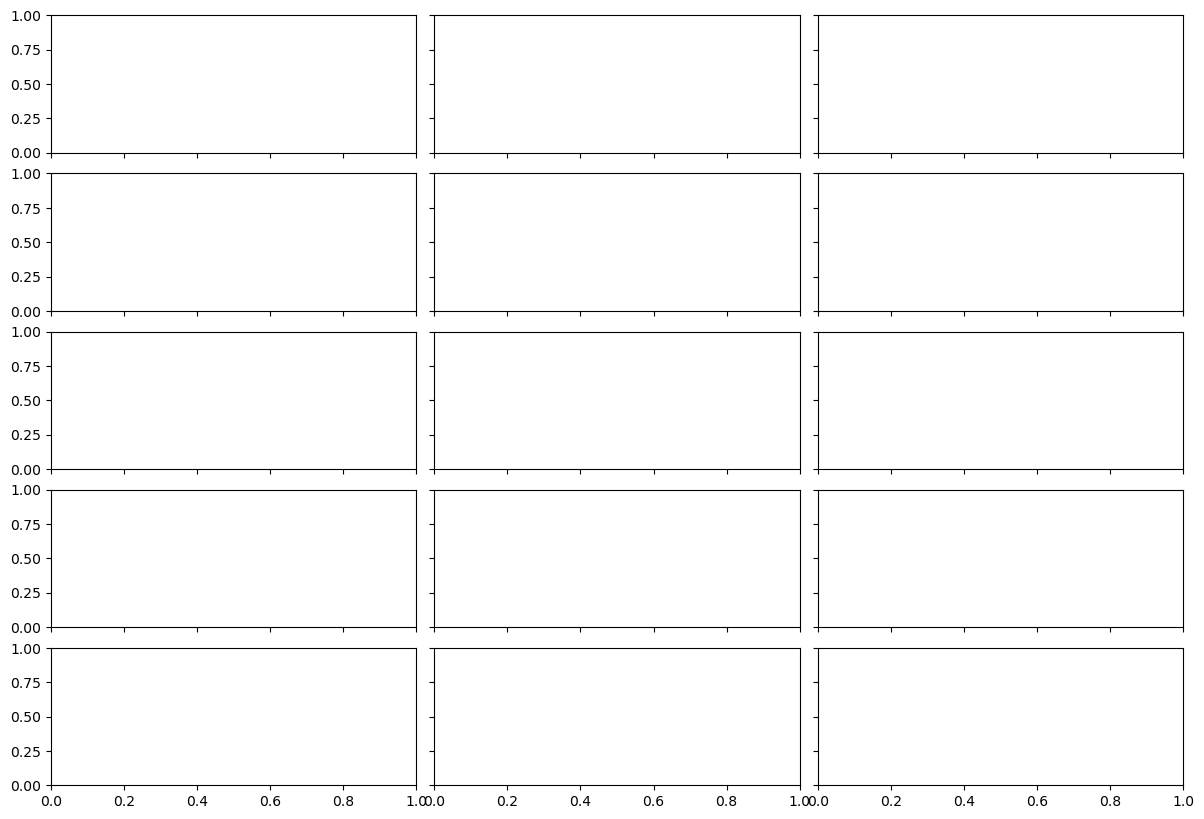

In [12]:
# ------------------
# Imshow panels of ζ/f for one time, across scales (Sim / Extracted / Posterior)
# ------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# choose a time index to display
t_show = 50
rng = np.random.default_rng(0)

def finite_sym_clim(arrs, q=99.0):
    """Symmetric vmin/vmax from percentile of absolute values across a list of arrays."""
    vals = np.concatenate([np.ravel(a[np.isfinite(a)]) for a in arrs])
    a = np.percentile(np.abs(vals), q)
    return (-a, a)


nrows = len(SCALES)
ncols = 3
fig, axes = plt.subplots(
    nrows, ncols, 
    figsize=(5*ncols, 2*nrows), 
    sharex=True, sharey=True,
    gridspec_kw={"wspace": 0.05, "hspace": 0.15, "right": 0.88}  #space for colorbars
)

if nrows == 1:
    axes = np.atleast_2d(axes)  # ensure 2D for uniform indexing

col_titles = ["Simulation ζ/f", "Extracted ζ/f", "Posterior ζ/f"]

for i, km in enumerate(SCALES):
    # load SSH fields already filtered to this scale
    ht_no_all = np.asarray(load(path_nonoise(km)), dtype=float)   # (T, y, x)
    ht_wi_all = np.asarray(load(path_withnoise(km)), dtype=float) # (T, y, x)
    ny, nx = ht_no_all.shape[1:]

    sy, sx = sigma_pixels(km, dx_m, dy_m)

    # --- Simulation and Extracted vorticity (ζ/f) at t_show ---
    z_sim = swot.compute_geostrophic_vorticity_5pt(ht_no_all[t_show], dx_m, dy_m, lat_1d)
    z_ext = swot.compute_geostrophic_vorticity_5pt(ht_wi_all[t_show], dx_m, dy_m, lat_1d)

    # --- Posterior sample at t_show: draw, smooth to this scale, then ζ/f ---
    mu_cm = ht_1km_all[t_show].ravel() * 100.0   # cm
    N = mu_cm.size
    z = rng.standard_normal(N)                   # one sample
    ssh_post = (mu_cm + (L @ z)) / 100.0         # meters
    ssh_post = ssh_post.reshape(ny, nx)
    ssh_post_smooth = gaussian_filter(ssh_post, sigma=(sy, sx), mode="reflect")
    z_post = swot.compute_geostrophic_vorticity_5pt(ssh_post_smooth, dx_m, dy_m, lat_1d)

    # symmetric color scale per row for fair comparison
    vmin, vmax = finite_sym_clim([z_sim, z_ext, z_post], q=99.0)

    # plot 3 columns
    ims = [
        axes[i, 0].imshow(z_sim.T, origin="lower", cmap="RdBu_r", vmin=vmin, vmax=vmax),
        axes[i, 1].imshow(z_ext.T, origin="lower", cmap="RdBu_r", vmin=vmin, vmax=vmax),
        axes[i, 2].imshow(z_post.T, origin="lower", cmap="RdBu_r", vmin=vmin, vmax=vmax),
    ]

    # titles and row label
    axes[i, 0].set_ylabel(f"{km} km", rotation=90)
    if i == 0:
        for j in range(ncols):
            axes[i, j].set_title(col_titles[j], fontsize=11)

    # add one colorbar per row (use the first image)
    cbar = fig.colorbar(ims[2], ax=axes[i, :], orientation="vertical", fraction=0.025, shrink = 0.5, pad=0.01)
    cbar.set_label("ζ / f", rotation=90)

# tidy
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle(f"ζ/f at t = {t_show}", y=0.995)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
